In [66]:
import numpy as np
import matplotlib.pyplot as plt

nx = 31
x = np.linspace(0,3,nx)
dx = x[2] - x[1]
gamma = 1.4
gamma_inverse = 1/gamma;
nt = 1400
cfl = 0.5
total_time = 0;
Cx = 0.2

rho = np.zeros((nx))
T = np.zeros((nx))
A = np.zeros((nx))
v = np.zeros((nx))
P = np.zeros((nx))
mach_number = np.zeros((nx))
mass_flow = np.zeros((nx))

rho_throat = np.zeros((nt))
pressure_throat = np.zeros((nt))
velocity_throat = np.zeros((nt))
temp_throat = np.zeros((nt))
mach_number_throat = np.zeros((nt))
mass_flow_throat = np.zeros((nt))

#Initial profile
for i in range(nx):
    if x[i] <=0.5:
        rho[i] = 1
        T[i] = 1
    elif(x[i] > 0.5 and x[i] <= 1.5):
        rho[i] = 1 - 0.366*(x[i] - 0.5)
        T[i] = 1 - 0.167*(x[i] - 0.5)
    elif(x[i]>1.5 and x[i]<=2.1):
        rho[i] = 0.634 - 0.3879*(x[i]-1.5)
        T[i] = 0.833 - 0.3507*(x[i]-1.5)
    elif(x[i] > 2.1 and x[i] <= 3):
        rho[i] = 0.5892 + 0.10228*(x[i] - 2.1)
        T[i] = 0.93968 + 0.0622*(x[i] - 2.1)

    A[i] = 1 + 2.2*((x[i]-1.5)**2)
    v[i] = 0.59/(rho[i]*A[i])
    P[i] = rho[i]*T[i]
    mass_flow[i] = rho[i]*v[i]*A[i]
    
mass_flow_rate_initial = rho*v*A
throat = np.where(A == 1)
throat = throat[0]

In [67]:
#Initial Solution
U1 = np.zeros((nx))
U2 = np.zeros((nx))
U3 = np.zeros((nx))

U1_old = np.zeros((nx))
U2_old = np.zeros((nx))
U3_old = np.zeros((nx))

F1 = np.zeros((nx))
F2 = np.zeros((nx))
F3 = np.zeros((nx))
J = np.zeros((nx))

dU1_dt_p = np.zeros((nx))
dU2_dt_p = np.zeros((nx))
dU3_dt_p = np.zeros((nx))

dU1_dt_c = np.zeros((nx))
dU2_dt_c = np.zeros((nx))
dU3_dt_c = np.zeros((nx))

dU1_dt_av = np.zeros((nx))
dU2_dt_av = np.zeros((nx))
dU3_dt_av = np.zeros((nx))

S1 = np.zeros((nx))
S2 = np.zeros((nx))
S3 = np.zeros((nx))

for i in range(nx):
    U1[i] = rho[i]*A[i]
    U2[i] = rho[i]*A[i]*v[i]
    U3[i] = rho[i]*(T[i]/(gamma - 1) + (gamma/2)*(v[i]**2))*A[i]

In [68]:
for time in range(nt):

    U1_old = U1.copy()
    U2_old = U2.copy()
    U3_old = U3.copy()

    dt=np.min((0.5*dx)/(T**0.5 + v))
    print(dt)

    for i in range(nx):
        F1[i] = U2[i]
        F2[i] = ((U2[i]**2)/U1[i]) + (((gamma-1)/gamma))*(U3[i] - ((gamma/2)*((U2[i]**2)/U1[i])))
        F3[i] = (gamma*((U2[i]*U3[i])/U1[i])) - (gamma*(gamma-1)/2)*(U2[i]**3/U1[i]**2)
    
    for i in range(1,nx-1):
        S1[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U1[i+1] - 2*U1[i] + U1[i-1])
        S2[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U2[i+1] - 2*U2[i] + U2[i-1])
        S3[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U3[i+1] - 2*U3[i] + U3[i-1])

    #Predictor step
    for i in range (1,nx-1):
        dA_dx = (A[i+1] - A[i])/dx
        J[i] = gamma_inverse*rho[i]*T[i]*dA_dx

        dU1_dt_p[i] = -((F1[i+1] - F1[i])/dx)
        dU2_dt_p[i] = -((F2[i+1] - F2[i])/dx) + J[i]
        dU3_dt_p[i] = -((F3[i+1] - F3[i])/dx)

        #solution update    
        U1[i] = U1[i] + dU1_dt_p[i]*dt + S1[i]
        U2[i] = U2[i] + dU2_dt_p[i]*dt + S2[i]#S2 
        U3[i] = U3[i] + dU3_dt_p[i]*dt + S3[i]#S3


    #getting the primitives
    for i in range(1,nx-1):
        rho[i] = U1[i]/A[i]
        v[i] = U2[i]/U1[i]
        T[i] = (gamma - 1)*((U3[i]/U1[i]) - ((gamma/2)*(v[i]**2)))
        P[i] = rho[i]*T[i]

    #updating F values
    for i in range(1,nx-1):
        F1[i] = U2[i]
        F2[i] = ((U2[i]**2)/U1[i]) + (((gamma-1)/gamma))*(U3[i] - ((gamma/2)*((U2[i]**2)/U1[i])))
        F3[i] = gamma*(U2[i]*U3[i]/U1[i]) - (gamma*(gamma-1)/2)*(U2[i]**3/U1[i]**2)

    #update S
    for i in range(1,nx-1):
        S1[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U1[i+1] -2*U1[i] + U1[i-1])
        S2[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U2[i+1] -2*U2[i] + U2[i-1])
        S3[i] = Cx*(abs(P[i-1] - 2*P[i] + P[i+1])/(P[i-1] + 2*P[i] + P[i+1]))*(U3[i+1] -2*U3[i] + U3[i-1])
    #Corrector Step
    for i in range(nx-2,0,-1):
        dA_dx = (A[i] - A[i-1])/dx
        J[i] = gamma_inverse*rho[i]*T[i]*dA_dx

        dU1_dt_c[i] = -((F1[i] - F1[i-1])/dx)
        dU2_dt_c[i] = -((F2[i] - F2[i-1])/dx) + J[i]
        dU3_dt_c[i] = -((F3[i] - F3[i-1])/dx)
    
       
        #Final solution update 
        U1[i] = U1_old[i] + 0.5*(dU1_dt_p[i] + dU1_dt_c[i])*dt + S1[i]#S1
        U2[i] = U2_old[i] + 0.5*(dU2_dt_p[i] + dU2_dt_c[i])*dt + S2[i] #S2
        U3[i] = U3_old[i] + 0.5*(dU3_dt_p[i] + dU3_dt_c[i])*dt + S3[i]#S3
    #Applying boundary condition

    #inlet
    U1[0] = rho[0]*A[0]
    U2[0] = 2*U2[1] - U2[2]
    U3[0] = U1[0]*((T[0]/(gamma-1)) + (gamma/2)*(v[0]**2))

    #outlet
    U1[nx-1] = 2*U1[nx-2] - U1[nx-3]
    U2[nx-1] = 2*U2[nx-2] - U2[nx-3]
    U3[nx-1] = ((P[nx-1]*A[nx-1])/(gamma - 1)) + (gamma/2)*(U2[nx-1])*(v[nx-1])

    
    rho = U1/A
    v = U2/U1
    T = (gamma - 1)*((U3/U1) - ((gamma/2)*(v**2)))
    P = rho*T
    mass_flow = rho*A*v
    mach_number = v/T**0.5


    #calculating variables in throat
    rho_throat[time] = rho[throat] 
    pressure_throat[time] = P[throat] 
    velocity_throat[time] = v[throat] 
    temp_throat[time] = T[throat] 
    mach_number_throat[time] = mach_number[throat] 
    mass_flow_throat[time] = mass_flow[throat]


0.026835867603327315
0.026666333655979448
0.02650709228891952
0.026301167581339623
0.026144363563928366
0.026033344807750342
0.025886742272311542
0.02573771266644746
0.025627391682570222
0.025548663099856556
0.025428034603831234
0.025308482263872317
0.02521120236071624
0.025128836501300354
0.02505449507527548
0.02498231218590057
0.024907860152543714
0.024828345743997903
0.02474255513222193
0.02465057665555182
0.024553385469965116
0.02445239812374135
0.024349092321328803
0.02424474969720925
0.024140336164804578
0.024036498154362373
0.023933639178819757
0.02383203927255229
0.023731971122021134
0.023633790374433642
0.023537984506092995
0.02344519365308824
0.023356180219476053
0.023271778766214658
0.023192832701407432
0.023120128922084173
0.023054339168142653
0.022995973833072055
0.022945351050836765
0.022902581484362073
0.022867567544553113
0.02284001474491692
0.0228194526198242
0.02280526261386203
0.022796710578113097
0.02279298180800274
0.02279321684977847
0.022796546553198484
0.0228021

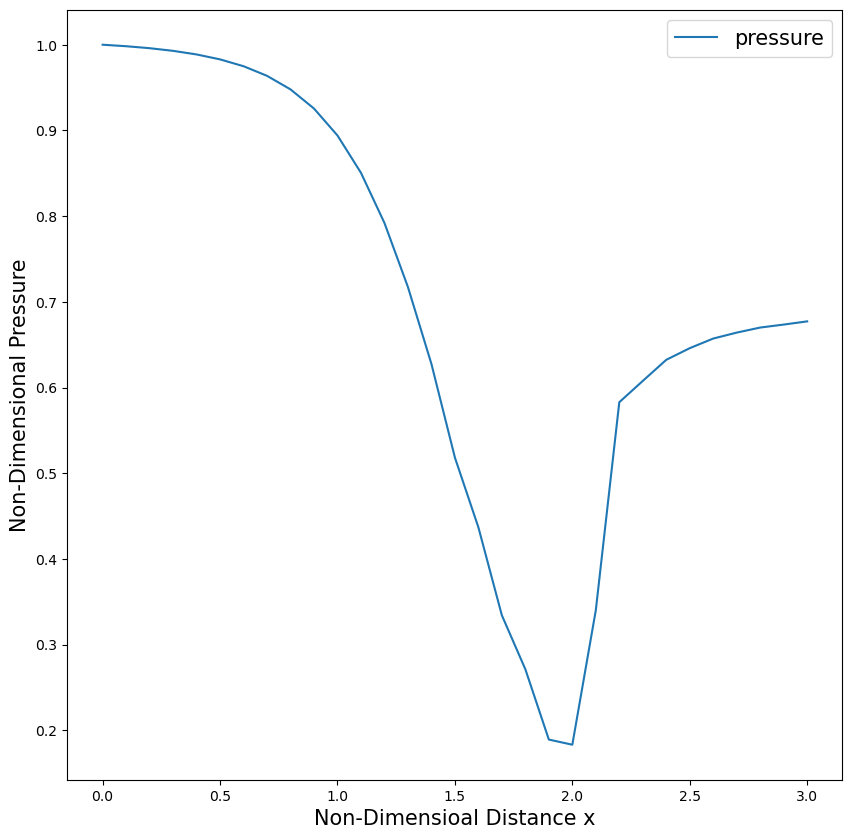

In [69]:
fig = plt.figure(figsize=(10,10), dpi = 100)
ax = fig.add_subplot(111)

ax.plot(x[:], P[:],label = 'pressure', linewidth = 1.5)
ax.set_xlabel("Non-Dimensioal Distance x")
ax.set_ylabel("Non-Dimensional Pressure")
plt.rc('axes', labelsize = 15)
ax.legend(prop={'size': 15})

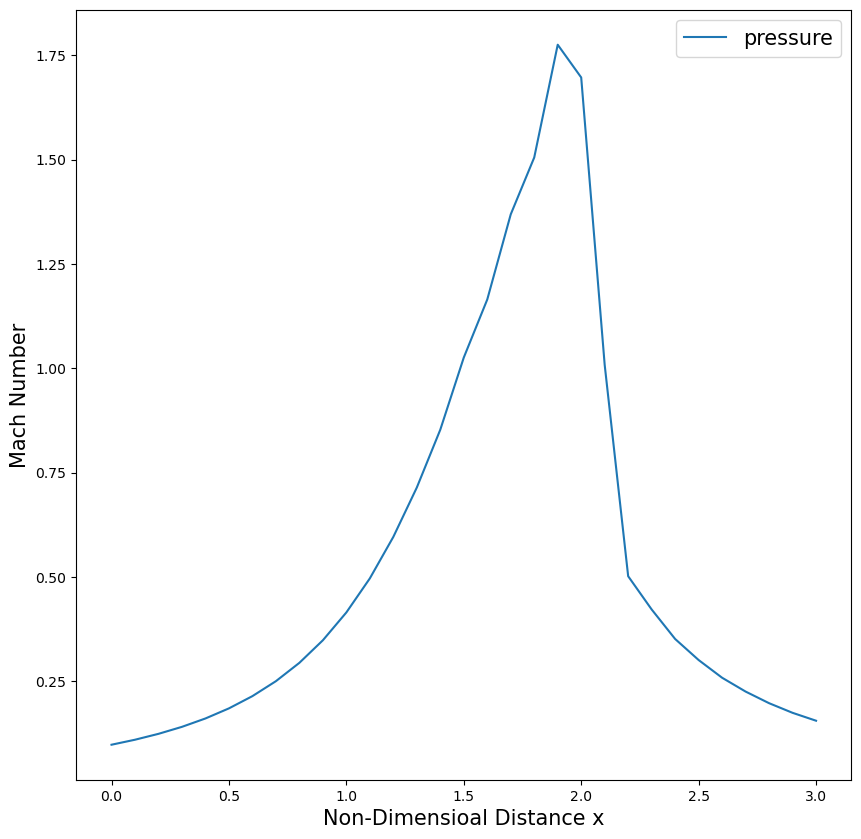

In [70]:
fig = plt.figure(figsize=(10,10), dpi = 100)
ax = fig.add_subplot(111)

ax.plot(x[:], mach_number[:],label = 'pressure', linewidth = 1.5)
ax.set_xlabel("Non-Dimensioal Distance x")
ax.set_ylabel("Mach Number")
plt.rc('axes', labelsize = 15)
ax.legend(prop={'size': 15})